In [2]:
import os
import statsmodels.api as sm
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Load and preprocess the dataset

In [32]:
data_dir = r"C:\Users\ESRA  ABLAK\Desktop\TomandJerry\tom_and_jerry\tom_and_jerry"


image_size = (224,224)

In [4]:
data = []
labels = []
subfolders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(data_dir,subfolder)
    image_files = os.listdir(folder_path)
    for image_file in image_files:
        data.append(os.path.join(subfolder, image_file))
        labels.append(label)
        
df = pd.DataFrame({"image_file": data, "label":labels})

In [5]:
df

,image_file,label
0,jerry\frame100.jpg,0
1,jerry\frame1032.jpg,0
2,jerry\frame1033.jpg,0
3,jerry\frame1034.jpg,0
4,jerry\frame1035.jpg,0
...,...,...
5473,tom_jerry_1\frame936.jpg,3
5474,tom_jerry_1\frame937.jpg,3
5475,tom_jerry_1\frame938.jpg,3
5476,tom_jerry_1\frame939.jpg,3


* The holdout method

In [6]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(df, test_size=0.1, random_state=42)

**Define a neural network model  -                                            Defining the base mode InceptionV3**

In [7]:
def create_model():
    base_model = InceptionV3(include_top=False, weights="imagenet", 
                             input_shape=(*image_size,3))
#include_top = whether to include the fully-connected layer 
#weights = None (random initialization), imagenet (pre-treaning on ImageNet)

    x = base_model.output # access the output of InV3 model
    x = GlobalAveragePooling2D()(x) # GAP => reduces dimensions
    x = Dense(512, activation="relu")(x) # add fully connected layer
    predictions = Dense(len(subfolders), activation="softmax")(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_model()

### Compile the model

In [8]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

### Train the model on training data

In [9]:
batch_size = 32
epochs = 10

train_datagen = ImageDataGenerator(rescale=1/255, horizontal_flip=True,
                                  rotation_range=30)
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = data_dir,
    x_col = "image_file",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "raw")

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = data_dir,
    x_col = "image_file",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "raw")



Found 4930 validated image filenames.
Found 548 validated image filenames.


In [50]:
history = model.fit(train_generator, epochs=epochs,
                    validation_data = val_generator)

Epoch 1/10
155/155 [==============================] - 909s 6s/step - loss: 0.7611 - accuracy: 0.7207 - val_loss: 7.0922 - val_accuracy: 0.3193
Epoch 2/10
155/155 [==============================] - 892s 6s/step - loss: 0.4262 - accuracy: 0.8600 - val_loss: 2.1759 - val_accuracy: 0.4781
Epoch 3/10
155/155 [==============================] - 880s 6s/step - loss: 0.3667 - accuracy: 0.8882 - val_loss: 0.8069 - val_accuracy: 0.7792
Epoch 4/10
155/155 [==============================] - 880s 6s/step - loss: 0.2965 - accuracy: 0.9022 - val_loss: 0.2716 - val_accuracy: 0.9106
Epoch 5/10
155/155 [==============================] - 863s 6s/step - loss: 0.2409 - accuracy: 0.9274 - val_loss: 0.9853 - val_accuracy: 0.7628
Epoch 6/10
155/155 [==============================] - 847s 5s/step - loss: 0.3303 - accuracy: 0.8913 - val_loss: 1.3460 - val_accuracy: 0.7135
Epoch 7/10
155/155 [==============================] - 803s 5s/step - loss: 0.2408 - accuracy: 0.9270 - val_loss: 0.3504 - val_accuracy: 0.8978

In [18]:
"""import pickle

file = "model.save"
pickle.dump(model, open(file,"wb"))"""

In [36]:
"""import pickle
load = pickle.load(open("model.save","rb"))
# load = model"""

In [37]:
"""model = load"""

### Evaluate the model on the validation data

In [12]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

18/18 [==============================] - 24s 1s/step - loss: 0.2636 - accuracy: 0.9179
Validation loss: 0.2635832130908966, Validation accuracy: 0.9178832173347473


In [13]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             loss = "sparse_categorical_crossentropy",
             metrics=["accuracy"])

fine_tune_epochs = 10

history_fine_tune = model.fit(train_generator,
                            epochs=epochs + fine_tune_epochs,
                            initial_epoch = history.epoch[-1],
                            validation_data = val_generator)

### Evaluate the fine-tuned model on the validation data

In [17]:
val_loss_fine_tune, val_accuracy_fine_tune = model.evaluate(val_generator)
print(f'Validation loss (fine-tuned): {val_loss_fine_tune}, Validation accuracy (fine-tuned): {val_accuracy_fine_tune}')

18/18 [==============================] - 23s 1s/step - loss: 0.2636 - accuracy: 0.9179
Validation loss (fine-tuned): 0.263583242893219, Validation accuracy (fine-tuned): 0.9178832173347473


### Evaluate the model on the test data

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = data_dir,
    x_col = "image_file",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "raw")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

Found 1096 validated image filenames.
35/35 [==============================] - 46s 1s/step - loss: 0.1881 - accuracy: 0.9361
Test loss: 0.18806339800357819, Test accuracy: 0.9361313581466675


### Use case 1

* Detect the presence of characters "tom" and "jerry" in any given image

1/1 [==============================] - 2s 2s/step


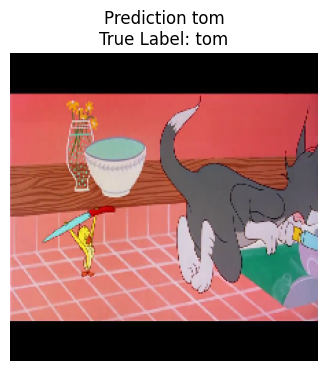

1/1 [==============================] - 0s 98ms/step


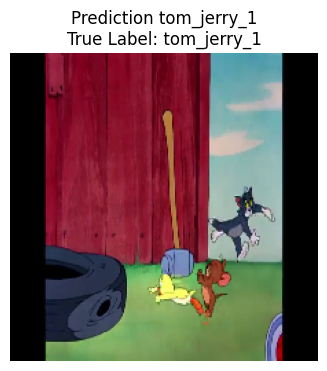

1/1 [==============================] - 0s 119ms/step


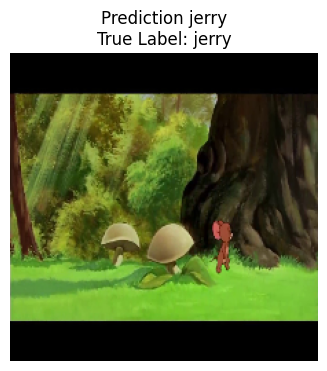

1/1 [==============================] - 0s 133ms/step


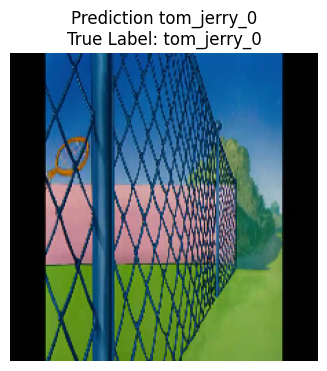

1/1 [==============================] - 0s 98ms/step


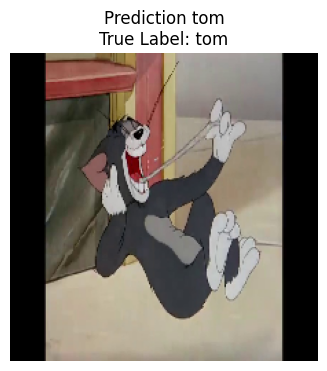

In [19]:
import matplotlib.pyplot as plt
import os

def display_image_predictions(df, data_dir, model):
    subset = df.sample(5, random_state=42)
    image_paths = subset["image_file"].apply(lambda x: os.path.join(data_dir, x)).tolist()
    true_labels = subset["label"].tolist()
    
    for i , image_path in enumerate(image_paths):
        img = tf.keras.preprocessing.image.load_img(image_path, target_size = image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        prediction = model.predict(img_array)
        predicted_label = subfolders[np.argmax(prediction)]
        
        plt.figure(figsize=(8,4))
        plt.imshow(img)
        title = f"Prediction {predicted_label}"
        if true_labels is not None:
            title += f"\nTrue Label: {subfolders[true_labels[i]]}"
        plt.title(title)
        plt.axis("off")
        plt.show()
        
display_image_predictions(df,data_dir,model)

In [20]:
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 93.61%


In [58]:
import pickle

file = "model.save"
pickle.dump(model, open(file,"wb"))

In [11]:
import pickle
load = pickle.load(open("model.save","rb"))
model = load

### Use case 2

In [21]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis = 1)
screen_time = np.bincount(predicted_labels)

for i, folder in enumerate(subfolders):
    print(f"Screen time for {folder}: {screen_time[i]} seconds")

35/35 [==============================] - 42s 1s/step
Screen time for jerry: 248 seconds
Screen time for tom: 382 seconds
Screen time for tom_jerry_0: 285 seconds
Screen time for tom_jerry_1: 181 seconds


In [22]:
import matplotlib.pyplot as plt

# calculating screen time for each character
screen_time = df["label"].value_counts().to_dict()
characters = [subfolders[label] for label in sorted(screen_time.keys())]
time_in_seconds = [screen_time[label] for label in sorted(screen_time.keys())]

print(characters)
print(time_in_seconds)

['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']
[1240, 1930, 1528, 780]


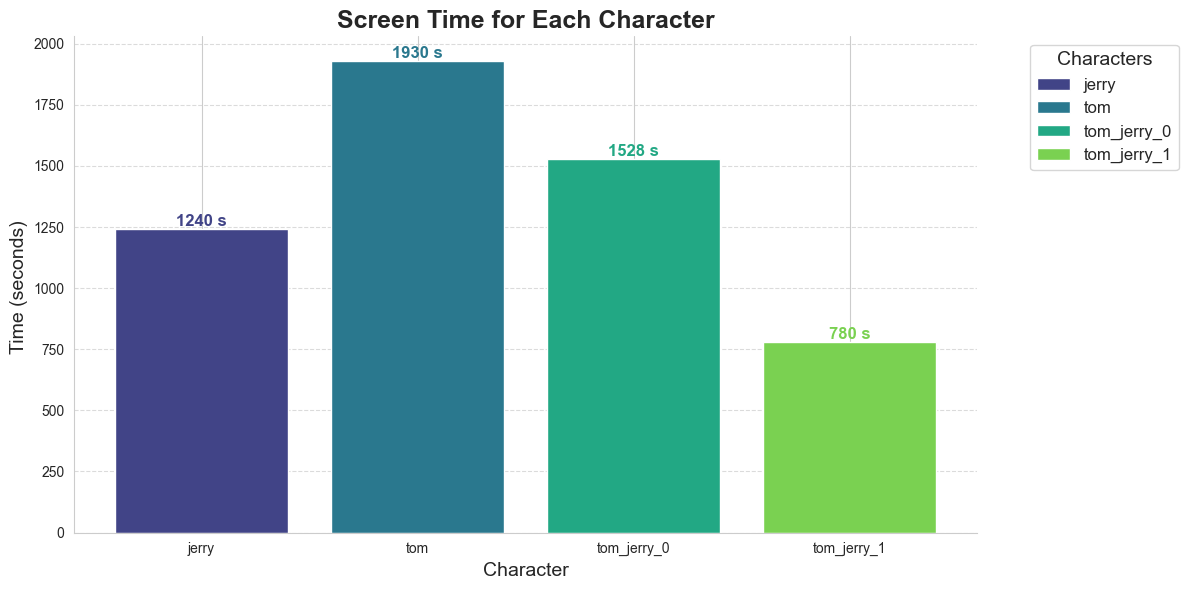

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

colors = sns.color_palette("viridis", len(characters))

bars = plt.bar(characters, time_in_seconds, color = colors)

plt.title("Screen Time for Each Character", fontsize=18, fontweight="bold")
plt.xlabel("Character", fontsize=14)
plt.ylabel("Time (seconds) ", fontsize=14)

for bar, color in zip(bars, colors):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height} s",
            ha = "center", va = "bottom", color = color, 
             fontsize = 12, fontweight = "bold")

plt.yticks = (range(0, max(time_in_seconds) + 100, 500), 
              [f"{i}s " for i in range(0,max(time_in_seconds) + 100, 500)])

sns.despine()

plt.ylim(0, max(time_in_seconds) + 100)
plt.grid(axis = "y", linestyle="--", alpha=0.7)
plt.legend(bars, characters, title="Characters", bbox_to_anchor=(1.05, 1),
          loc="upper left", fontsize="12", title_fontsize="14")
plt.tight_layout()
plt.show()

### Use case 3

In [24]:
tom_jerry_1_images = df[df["label"] == 3]["image_file"].tolist()
file_numbers = [int(name.split('/')[-1].replace('tom_jerry_','').replace('\\frame', '').replace('.jpg', '')) for name in tom_jerry_1_images]
sorted_numbers = sorted(file_numbers)
max_duration = 0
current_duration = 1

for i in range(1, len(sorted_numbers)):
    if sorted_numbers[i] - sorted_numbers[i-1] == 1:
        current_duration += 1
    else:
        if current_duration > max_duration:
            max_duration = current_duration
        current_duration = 1
        
print(f"Max continuous screen time for both Tom & Jerry: {max_duration} seconds")

Max continuous screen time for both Tom & Jerry: 34 seconds


#### Error Analysis
* Number of images incorrectly classified

In [25]:
data_generator = ImageDataGenerator(rescale=1./255)

all_data_generator = data_generator.flow_from_dataframe(
    dataframe = df,
    directory = data_dir,
    x_col = "image_file",
    y_col = "label",
    class_mode = "raw",
    target_size = image_size,
    batch_size = 32,
    shuffle = False)

predicted_labels_all = model.predict(all_data_generator)

df["label"] = df["label"].astype(int)

incorrectly_classified = df[df["label"] != np.argmax(predicted_labels_all,
                                                    axis = 1)]
print(f"Number of images incorrectly classified: {len(incorrectly_classified)}")

Found 5478 validated image filenames.
172/172 [==============================] - 259s 2s/step
Number of images incorrectly classified: 275


In [26]:
incorrectly_classified

,image_file,label
15,jerry\frame1084.jpg,0
17,jerry\frame1087.jpg,0
21,jerry\frame1102.jpg,0
22,jerry\frame1103.jpg,0
23,jerry\frame1110.jpg,0
...,...,...
5407,tom_jerry_1\frame736.jpg,3
5432,tom_jerry_1\frame782.jpg,3
5437,tom_jerry_1\frame830.jpg,3
5450,tom_jerry_1\frame911.jpg,3


* Displaying Misclassified Images

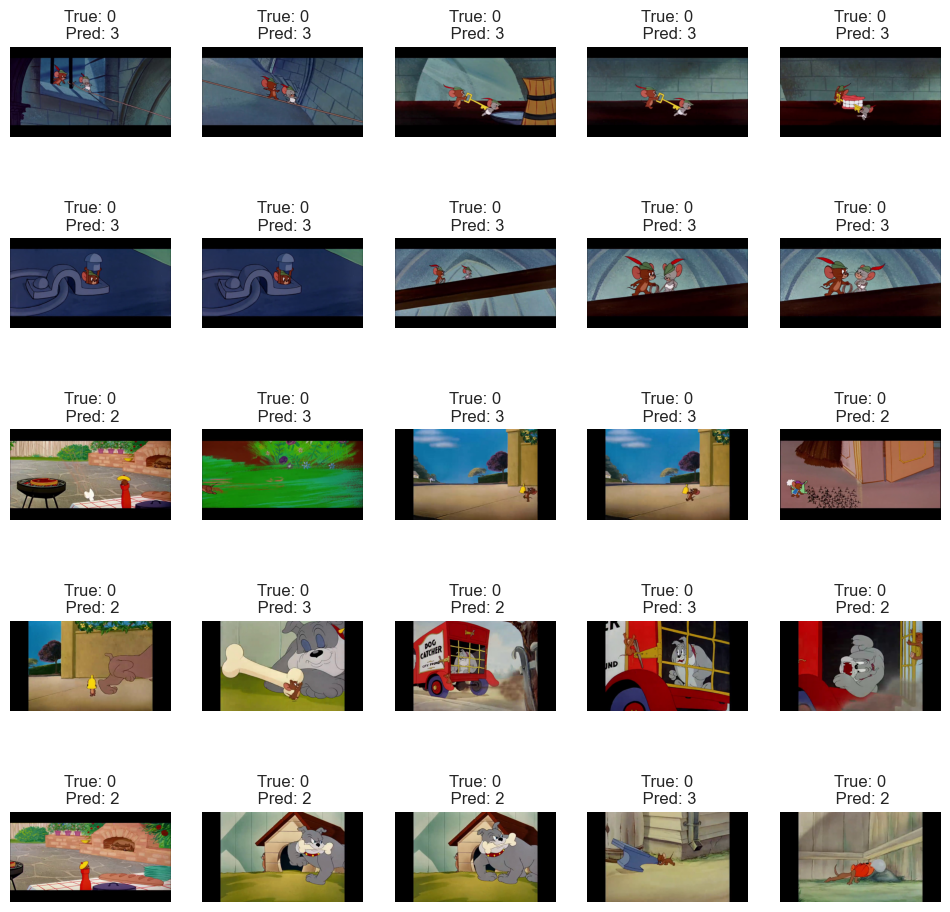

In [27]:
def plot_images(images, labels, predictions, grid_width=5,
               grid_height=5, figsize=(12,12)):
    fig, axes = plt.subplots(grid_height, grid_width, figsize=figsize)
    axes = axes.ravel()
    n_total = grid_width * grid_height
    
    for i in np.arange(0, n_total):
        if i < len(images):
            img = mpimg.imread(os.path.join(data_dir, images[i]))
            axes[i].imshow(img)
            axes[i].set_title(f"True: {labels[i]}\n Pred: {predictions[i]}",
                            fontsize=12)
            axes[i].axis("off")
        else:
            axes[i].axis("off")
            
incorrect_images = incorrectly_classified["image_file"].values[:25]
true_labels = incorrectly_classified["label"].values[:25]
predicted_labels = np.argmax(predicted_labels_all, axis=1)[incorrectly_classified.index][:25]

plot_images(incorrect_images, true_labels, predicted_labels)

### Character Co-occurence
* Explore how often different characters appear on screen together. This could give insights into character interactions and relationships.

In [28]:
co_occurence_matrix = np.zeros((len(subfolders), len(subfolders)))

for _, row in df.iterrows():
    co_occurence_matrix[row["label"], :] += 1
    co_occurence_matrix[:, row["label"]] += 1
    co_occurence_matrix[row["label"], row["label"]] -= 1
    
co_occurence_df =pd.DataFrame(co_occurence_matrix, index=subfolders,
                             columns=subfolders)

print(co_occurence_df)

              jerry     tom  tom_jerry_0  tom_jerry_1
jerry        1240.0  3170.0       2768.0       2020.0
tom          3170.0  1930.0       3458.0       2710.0
tom_jerry_0  2768.0  3458.0       1528.0       2308.0
tom_jerry_1  2020.0  2710.0       2308.0        780.0


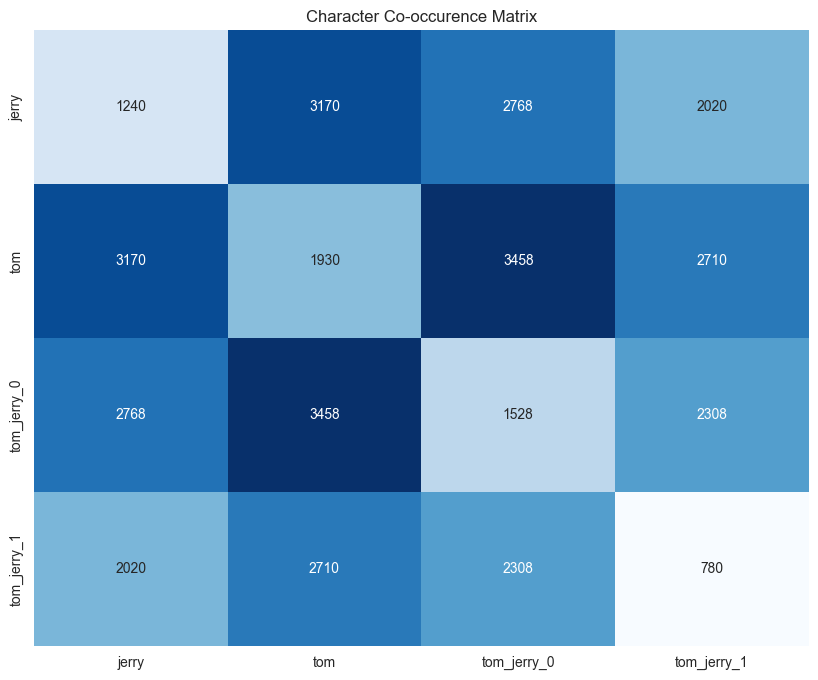

In [29]:
plt.figure(figsize=(10,8))
sns.heatmap(co_occurence_df, annot=True, fmt=".0f", cmap="Blues",cbar=False)
plt.title("Character Co-occurence Matrix")
plt.show()

### Frame-to-Frame Transitions

In [35]:
df['frame'] = df["image_file"].str.extract(r'frame(\d+).jpg').astype(int)
df = df.sort_values(by="frame").reset_index(drop=True)
df

,image_file,label,frame,transition
0,tom_jerry_0\frame0.jpg,2,0,no_transition
1,tom_jerry_0\frame1.jpg,2,1,no_transition
2,tom_jerry_0\frame2.jpg,2,2,no_transition
3,tom_jerry_0\frame3.jpg,2,3,no_transition
4,tom_jerry_0\frame4.jpg,2,4,no_transition
...,...,...,...,...
5473,tom_jerry_0\frame5473.jpg,2,5473,jerry_to_tom_jerry_0
5474,tom_jerry_0\frame5474.jpg,2,5474,no_transition
5475,tom_jerry_0\frame5475.jpg,2,5475,no_transition
5476,tom_jerry_0\frame5476.jpg,2,5476,no_transition


In [47]:
df['transition'] = df["label"].diff()
df["transition"] = df.apply(lambda row: f"{subfolders[int(row['label']) - int(row['transition'])]}_to_{subfolders[int(row['label'])]}" if row['transition'] != 0 and not pd.isna(row['transition']) else "no_transition", axis=1)

transitions = df[df["transition"] != "no_transition"]["transition"]
transition_counts = transitions.value_counts()

C:\Users\ESRA  ABLAK\AppData\Local\Temp\ipykernel_14984\2398462821.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=transition_counts.index, y=transition_counts.values,


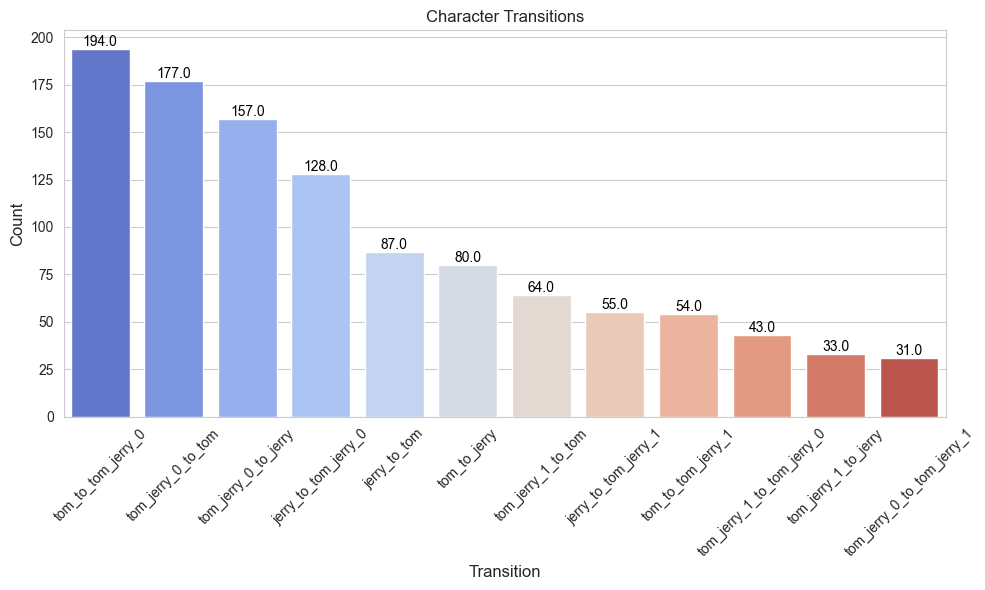

In [48]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=transition_counts.index, y=transition_counts.values,
                palette = "coolwarm")
plt.xticks(rotation=45)
plt.title("Character Transitions", fontsize=12)
plt.xlabel("Transition", fontsize=12)
plt.ylabel("Count",fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
    textcoords='offset points')

plt.tight_layout()
plt.show()

### Most Common Scenes

C:\Users\ESRA  ABLAK\AppData\Local\Temp\ipykernel_14984\2429419328.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=scene_counts.index, y=scene_counts.values, palette='muted')


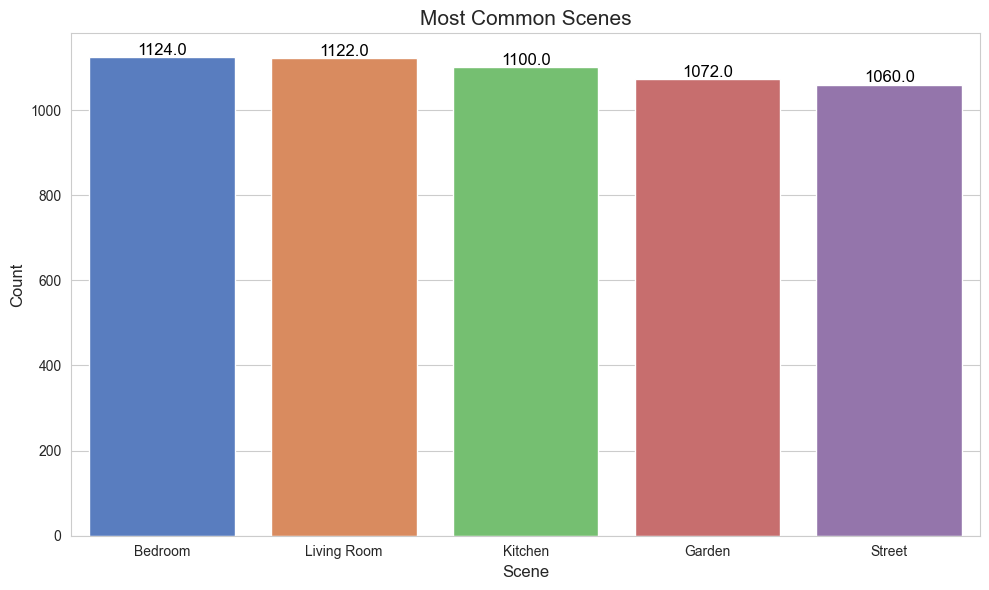

In [52]:
df = pd.DataFrame({'image_path': data, 'label': labels})
def identify_scence(image_path):
    scenes = ["Living Room","Kitchen","Garden","Street","Bedroom"]
    return np.random.choice(scenes)

df["scene"] = df["image_path"].apply(identify_scene)
scene_counts = df["scene"].value_counts()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=scene_counts.index, y=scene_counts.values, palette='muted')
plt.title('Most Common Scenes', fontsize=15)
plt.xlabel('Scene', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [53]:
df

,image_path,label,scene
0,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,0,Living Room
1,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,0,Bedroom
2,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,0,Living Room
3,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,0,Bedroom
4,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,0,Street
...,...,...,...
5473,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,3,Bedroom
5474,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,3,Kitchen
5475,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,3,Street
5476,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,3,Kitchen


# Predictive Modeling

### Step1: Extract Frame Number and Create Time Series Data

In [57]:
df = pd.DataFrame({'image_file': data, 'label': labels})
df["frame"] = df["image_file"].str.extract(r"frame(\d+).jpg").astype(int)
df.sort_values("frame",inplace=True)
df

,image_file,label,frame
3170,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,2,0
3171,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,2,1
3421,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,2,2
3717,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,2,3
4061,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,2,4
...,...,...,...
4525,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,2,5473
4526,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,2,5474
4527,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,2,5475
4528,C:\Users\ESRA ABLAK\Desktop\TomandJerry\tom_a...,2,5476


In [58]:
time_series_data = pd.DataFrame(index=df["frame"].unique())

for label in range(len(subfolders)):
    time_series_data[subfolders[label]] = 0
    frames = df[df["label"] == label]["frame"]
    time_series_data.loc[frames, subfolders[label]] = 1
    
time_series_data.head()

,jerry,tom,tom_jerry_0,tom_jerry_1
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


### Step 2:  Create a Predictive Model

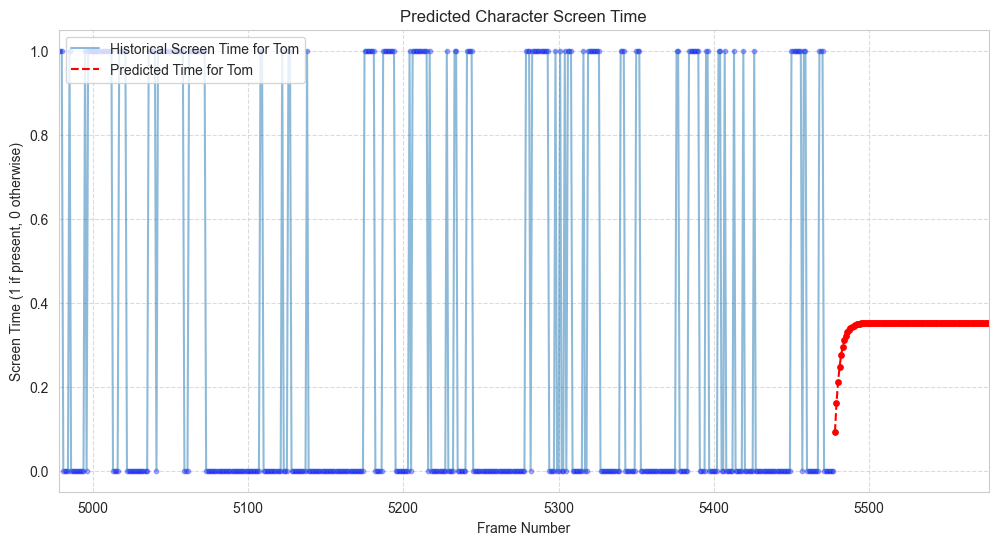

In [61]:
y = time_series_data["tom"]

model = sm.tsa.AutoReg(y, lags=1).fit()

predictions = model.predict(start=len(y), end=len(y) + 99, dynamic=True)

plt.figure(figsize=(12,6))
plt.plot(y.index, y.values, label="Historical Screen Time for Tom", 
         alpha = 0.5)
plt.scatter(y.index, y.values, alpha=0.3, s=10, color="blue")
plt.plot(predictions.index, predictions.values, linestyle="--",
         color="red", label = "Predicted Time for Tom ")
plt.scatter(predictions.index, predictions.values, color="red", s=15)

start_idx = max(0, len(y) - 500)
plt.xlim(start_idx, predictions.index[-1])


plt.xlabel('Frame Number')
plt.ylabel('Screen Time (1 if present, 0 otherwise)')
plt.title('Predicted Character Screen Time')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)


plt.show()

### Step 3: Visualize the Predictions

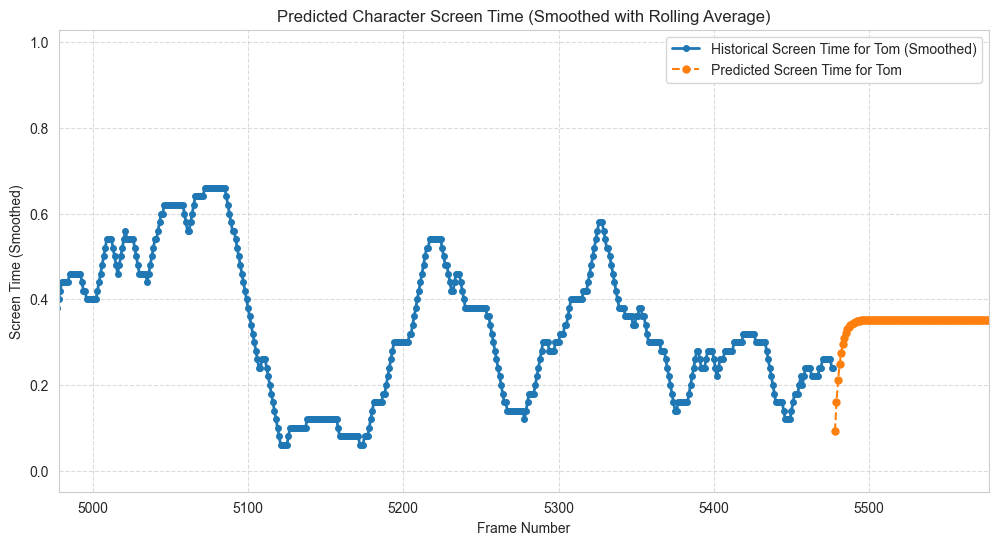

In [63]:
rolling_avg = y.rolling(window=50).mean()

plt.figure(figsize=(12,6))
plt.plot(rolling_avg.index, rolling_avg.values,
         label='Historical Screen Time for Tom (Smoothed)',
         linewidth=2, marker='o', markersize=4)
plt.plot(predictions.index, predictions.values, linestyle='--',
         label='Predicted Screen Time for Tom', marker='o', markersize=5)

start_idx = max(0, len(y) - 500)
plt.xlim(start_idx, predictions.index[-1])


plt.xlabel('Frame Number')
plt.ylabel('Screen Time (Smoothed)')
plt.title('Predicted Character Screen Time (Smoothed with Rolling Average)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()